# M11: Decision Tree versus Random Forest Performance
# DAV 6150

- Group Members: Qing Dou, Ruoyu Chen, Zhengnan Li

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Introduction
This project is to analyze the dataset comprised of information pertaining to NY State High School graduation metrics for the 2018-2019 school year. Our goal is to develop decision tree and random forest models to predict the reg_level in a school district or for a specific group of students. This prediction will be based on a variety of characteristics related to district characteristics, student groupings, and possibly other relevant factors such as socioeconomic status of students, geographic location of the district, school resources and capacity, etc. 

In short, we will apply the full data science project lifecycle to the implementation and evaluation of a series of random forset models that predict the number of student “reg_level” relative to certain properties/characteristics of a given school district and associated student subgrouping. 

### 1.1 Approach:
- [Introduction](#1-introduction): Import the data set and introduce data variables.  
- [EDA](#2-eda): Explore the raw dataset and do analysis based on domain knowledge.  
- [Data Preparation](#3-Data-Preparation): Perform data cleaning, imputation and transformation.  
- [Prepped Data Overview](#4-Prepped-Data-Overview): Re-run the EDA to ensure the data is well prepared for subsequent modeling.  
- [Decision Tree + Random Forest Modeling](#5-Regression-Modeling): Present decision tree and random forest modeling work, including feature selection / dimensionality reduction decisions and the process by which we selected the hyperparameters for models.  
- [Select Models](#6-Select-Models): Explain how we selected the model selection criteria.  
- [Conclusion](#7-Conclusion)

### 1.2 Data Introduction


The dataset is comprised of more than 73,000 observations, each of which pertains to a particular NY State school district and associated subgroupings/categorizations of high school students who had been enrolled for at least 4 years as of the end of the 2018-2019 school year. A data dictionary describing the attributes contained within the file is provided below.  
The dataset is sourced from the NY 
State Education Department (NYSED): https://data.nysed.gov/downloads.php
Read the data from our github repository. The dataframe is shown below.

In [2]:
school_raw = pd.read_csv("https://raw.githubusercontent.com/qdou14/DAV-6150/main/module%2011/M11_Data.csv")
school_raw.head()

,report_school_year,aggregation_index,aggregation_type,aggregation_name,nrc_code,nrc_desc,county_code,county_name,nyc_ind,membership_desc,subgroup_code,subgroup_name,enroll_cnt,grad_cnt,grad_pct,reg_cnt,reg_pct,dropout_cnt,dropout_pct
0,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,1,All Students,658,464,71%,310,47%,148,22%
1,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,2,Female,324,246,76%,169,52%,65,20%
2,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,3,Male,334,218,65%,141,42%,83,25%
3,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,4,American Indian/Alaska Native,-,-,-,-,-,-,-
4,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,5,Black,367,248,68%,183,50%,91,25%


In [3]:
school_raw.columns

Index(['report_school_year', 'aggregation_index', 'aggregation_type',
       'aggregation_name', 'nrc_code', 'nrc_desc', 'county_code',
       'county_name', 'nyc_ind', 'membership_desc', 'subgroup_code',
       'subgroup_name', 'enroll_cnt', 'grad_cnt', 'grad_pct', 'reg_cnt',
       'reg_pct', 'dropout_cnt', 'dropout_pct'],
      dtype='object')

In [4]:
school_raw.shape

(73152, 19)

# 2. Exploratory Data Analysis
In this part, we will explore the raw dataset and analyze the missing and invalid values, make histograms and other graphs to determine how to clean the data to improve its usability.  
First start with the matrix of the dataframe. The dataframe has 73152 rows of observations and 19 attributes. We will dive deeper into the dataframe by looking at different columns.

In this dataset all the missing value are marked as "-" and we need to turn them into NaN.  
And alter the percentage data from string to float.

In [5]:
school_raw=school_raw[~school_raw['enroll_cnt'].isin(['-'])] 
school_raw['grad_pct'] = school_raw['grad_pct'].str.strip('%').astype(float)/100 
school_raw['reg_pct'] = school_raw['reg_pct'].str.strip('%').astype(float)/100 
school_raw['dropout_pct'] = school_raw['dropout_pct'].str.strip('%').astype(float)/100

school_raw["enroll_cnt"] = school_raw["enroll_cnt"].astype("float64")
school_raw["grad_cnt"] = school_raw["grad_cnt"].astype("float64")
school_raw["reg_cnt"] = school_raw["reg_cnt"].astype("float64")
school_raw["dropout_cnt"] = school_raw["dropout_cnt"].astype("int64")

Before starting, we define the functions to be used for EDA.

In [6]:
def create_subplots(attributes):
    max_cols_per_row = 5
    num_attributes = len(attributes)
    nrows = -(-num_attributes // max_cols_per_row) 
    ncols = min(num_attributes, max_cols_per_row)  
    figsize_width = ncols * 4 
    figsize_height = nrows * 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize_width, figsize_height), squeeze=False)
    return fig, axes

def hist(attributes):
    fig, axes = create_subplots(attributes)
    for i, attribute in enumerate(attributes):
        ax = axes[i // 5][i % 5] 
        sns.histplot(data=school_raw[attribute], ax=ax)
        ax.set_xlabel(attribute)
        ax.set_ylabel('')
    plt.show()

def box(attributes):
    fig, axes = create_subplots(attributes)
    for i, attribute in enumerate(attributes):
        ax = axes[i // 5][i % 5] 
        sns.boxplot(data=school_raw[attribute], ax=ax)
        ax.set_xlabel(attribute)
        ax.set_ylabel('')
    plt.show()

def bar(attributes):
    fig, axes = create_subplots(attributes)
    for i, attribute in enumerate(attributes):
        ax = axes[i // 5][i % 5]  
        sns.countplot(x=school_raw[attribute], ax=ax)
        ax.set_xlabel(attribute)
        ax.set_ylabel('')
        ax.tick_params(axis='x', rotation=90)
    plt.show()


| Variables                    | Definition                                                                                      | Data type  | Distribution | Correlation | Explanation                                                                                                                                                         |
|------------------------------|-------------------------------------------------------------------------------------------------|------------|--------------|-------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| report_school_year           | School year for which data is reported                                                          | Categorical| Uniform      | NA          | This variable is a fixed value only contain the 2018-2018 academic year.                                    |
| aggregation_index            | Numeric index for aggregation method                                                            | Categorical| Uniform      | NA          | Represents how the data is aggregated, which also only cantain one methods.                                                   |
| aggregation_type             | Type of aggregation used for data                                                               | Categorical| Uniform      | NA          | Describes the aggregation method used, which only have district value and not a predictive factor.                                     |
| aggregation_name             | Name of the aggregation, typically the name of the school district                             | Categorical| NA      | NA          | The name of the district school provides context but does not have predictive power in a regression model.                                                                 |

__Feature Selection:__   
The 'report_school_year', 'aggregation_index','aggregation_type' variable represent the school year and only has one unique value, which will not help with prediction. Thus can be dropped. For 'aggregation_name', we observe 680 distinct types of school districts, and the repetitions arise due to variations in subgroups and enrollment years. Since our analysis focuses on the relationship between dropout rates and subgroup, we can exclude 'aggregation_name' from our feature set.

In [7]:
display(school_raw["report_school_year"].unique())
display(school_raw["aggregation_index"].unique())
display(school_raw["aggregation_type"].unique())
display(school_raw["aggregation_name"].value_counts())

array(['2018-19'], dtype=object)

array([3], dtype=int64)

array(['District'], dtype=object)

aggregation_name
SYRACUSE CITY SCHOOL DISTRICT                         116
NEW YORK CITY GEOGRAPHIC DISTRICT #28                 108
NEW YORK CITY GEOGRAPHIC DISTRICT #14                 108
NEW YORK CITY GEOGRAPHIC DISTRICT # 3                 108
NEW YORK CITY GEOGRAPHIC DISTRICT #31                 108
                                                     ... 
KIRYAS JOEL VILLAGE UNION FREE SCHOOL DISTRICT          4
FISHERS ISLAND UNION FREE SCHOOL DISTRICT               4
LONG LAKE CENTRAL SCHOOL DISTRICT                       2
GREENBURGH-NORTH CASTLE UNION FREE SCHOOL DISTRICT      2
BERKSHIRE UNION FREE SCHOOL DISTRICT                    2
Name: count, Length: 677, dtype: int64

| Variables         | Definition                                                  | Data type   | Distribution | Correlation | Explanation                                                                                                       |
|-------------------|-------------------------------------------------------------|-------------|--------------|-------------|-------------------------------------------------------------------------------------------------------------------|
| nrc_code          | Code for needs/resource capacity                            | Categorical   | Varied       | Non_Linear      | 1 to 6 represent different district demand of capacity, same to the nrc_desc, which might correlate with dropout rates due to resource constraints. |
| nrc_desc          | Description of school district type based on needs/resource capacity | Categorical | Varied       | Non_Linear      | It might correlating with dropout rates. |
| county_code       | Numeric code for county name                                | Categorical   | Varied       | Non_Linear        | It provide 62 code of NY county, the code correspond to different regions, which could see in conty_name. |
| county_name       | Full name of applicable NY State county                    | Categorical | Varied       | Non_Linear         | It represents 62 county of NY with limited direct predictive value for dropout rates.     |
| nyc_ind           | Indicator of whether the school district resides within NYC | Binary      | Bi-modal     | Non_Linear      | Most schools are not in NYC, which might correlate with dropout rates due to urban vs. rural educational resource disparities.   |
| membership_desc   | School year in which students first enrolled in high school | Categorical | Varied       | Non_Linear         | Provides year of admission from 2013 to 2015 and the length of schooling. |

__Feature Selection:__   
Since we want to analyze the impact of distinct on dropout, and some columns represent the same meaning, for subsequent modeling, we can drop out the following columns: 'nrc_desc', 'county_name'.

In [8]:
display(school_raw["county_name"].value_counts())

county_name
SUFFOLK        3996
NASSAU         3152
WESTCHESTER    2700
ERIE           1770
MONROE         1356
               ... 
WYOMING         174
RICHMOND        108
YATES           100
SCHUYLER         94
HAMILTON         38
Name: count, Length: 62, dtype: int64

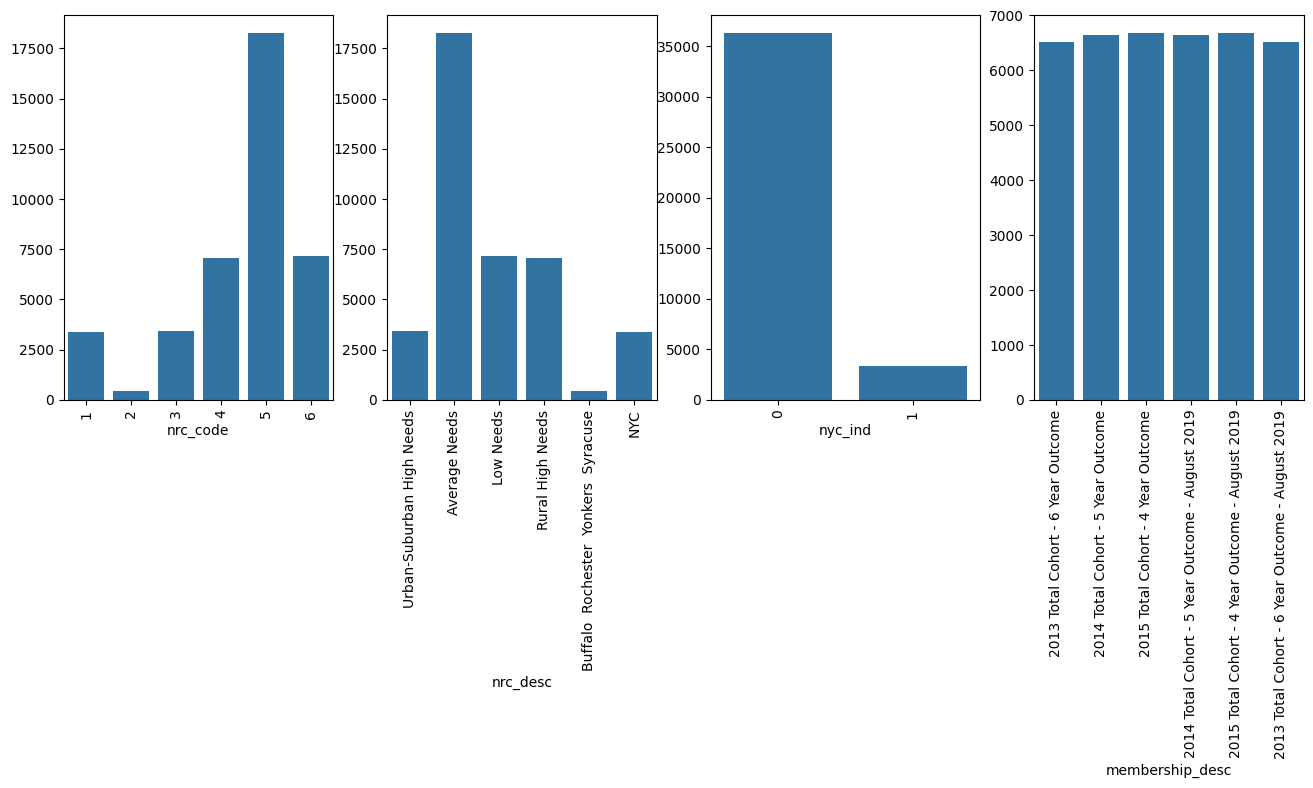

In [9]:
bar(['nrc_code','nrc_desc','nyc_ind','membership_desc'])

| Variables       | Definition                                 | Data type   | Distribution | Correlation | Explanation                                                                                                       |
|-----------------|--------------------------------------------|-------------|--------------|-------------|-------------------------------------------------------------------------------------------------------------------|
| subgroup_name/code   | Description of student subgrouping         | Categorical | Varied       | Non_Linear        | Including gender, race, whether to join the military, whether to be homeless, health level, etc.       |

__Feature Selection:__   
We can group 'subgroup_name' due to it represents different categories, which can  facilitate subsequent research.

In [10]:
display(school_raw["subgroup_name"].value_counts())

subgroup_name
All Students                         4046
Male                                 3970
Female                               3970
Economically Disadvantaged           3918
Not Economically Disadvantaged       3918
General Education Students           3632
Students with Disabilities           3632
White                                2790
Hispanic                             1878
Black                                1416
Asian/Pacific Islander               1122
Homeless                              962
Not Homeless                          962
English Language Learner              872
Not English Language Learner          872
Multiracial                           708
Formerly English Language Learner     572
American Indian/Alaska Native         270
In Foster Care                         36
Not in Foster Care                     36
Parent in Armed Forces                 28
Parent Not in Armed Forces             28
Migrant                                18
Not Migrant         

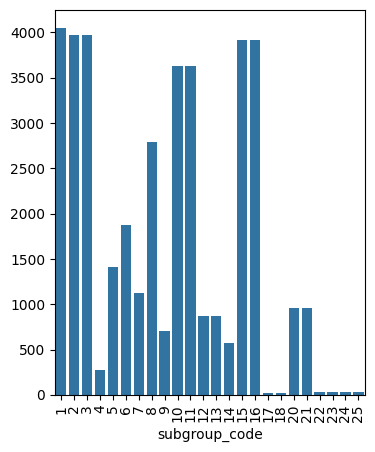

In [11]:
bar(['subgroup_code'])

| Variables                   | Definition                                                  | Data type   | Distribution   | Correlation    | Explanation                                                                                                                       |
|-----------------------------|-------------------------------------------------------------|-------------|----------------|----------------|-----------------------------------------------------------------------------------------------------------------------------------|
| enroll_cnt                  | Number of students enrolled                                 | Numerical   | Right-Skewed  | Non_Linear           | The total enrollment count could correlate with dropout rates; larger groups might have higher numbers of dropouts.     |
| grad_cnt/pct                    | Number of students graduated                                | Numerical   | Right-Skewed  | Non_Linear | The number of graduates correlates with dropouts, as higher graduation rates typically mean fewer dropouts.            |                                                   
| reg_cnt/pct                     | Students awarded a "Regents" diploma                        | Numerical   | Right-Skewed         | Non_Linear  | The Regents Scholarship, based on academic excellence, is a prestigious scholarship awarded to undergraduate student. |
| ged_cnt/pct                     | Students awarded a "GED" diploma                            | Numerical   | Right-Skewed         | Non_Linear         | Reflects students who obtained a GED, which means a test to examine the lining of the esophagus, stomach, and first part of the small intestine . |


__Feature Selection:__   
From the histogram and box plots, we can observe that most of the attributes have many outliers and do not follow a normal distribution. Only "reg_pct" follow nearly normal distribution. For features that do not follow a normal distribution, we can use a log transformation or other method to reduce skew and normalize the data.


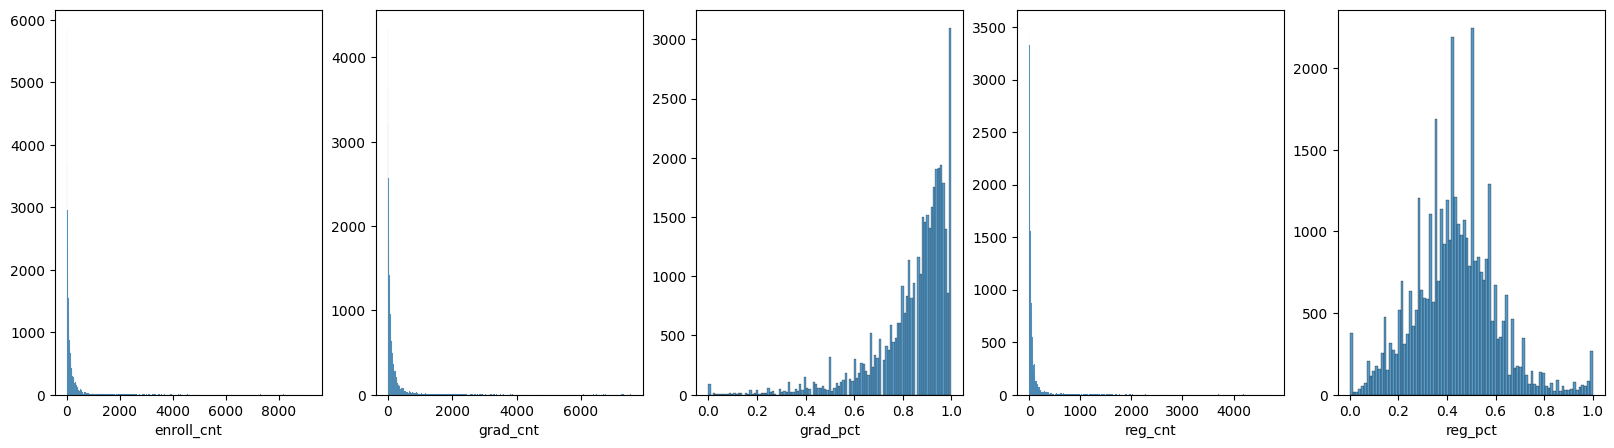

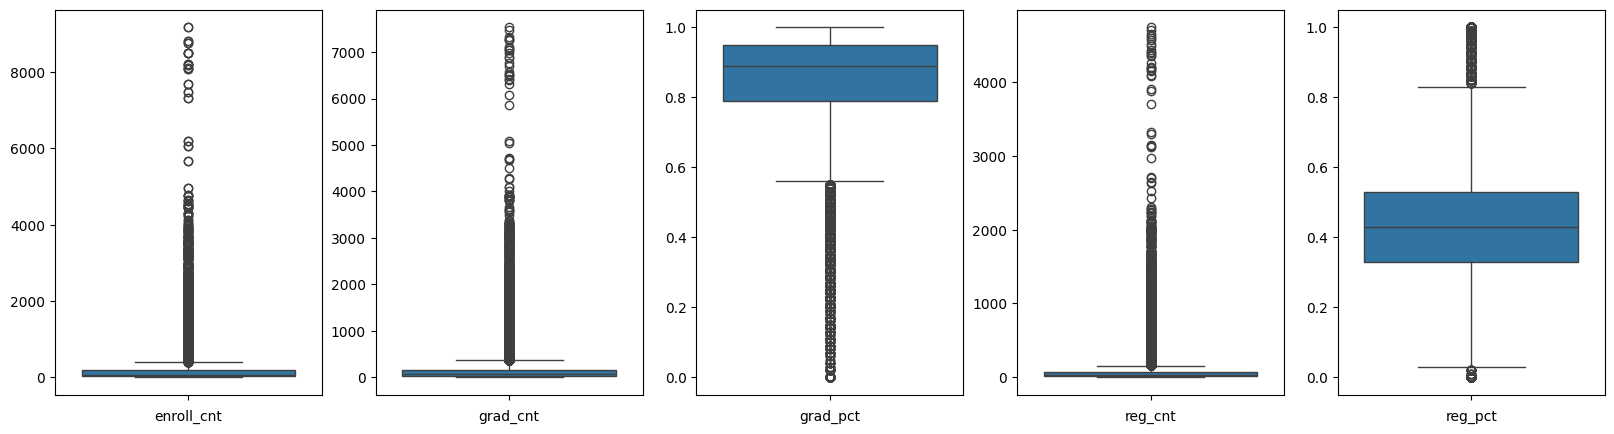

In [12]:
hist([ 'enroll_cnt', 'grad_cnt', 'grad_pct', 'reg_cnt', 'reg_pct'])
box(['enroll_cnt', 'grad_cnt', 'grad_pct', 'reg_cnt', 'reg_pct'])

| Variables     | Definition                                            | Data type   | Distribution | Correlation       | Explanation                                                                                                 |
|---------------|-------------------------------------------------------|-------------|--------------|-------------------|-------------------------------------------------------------------------------------------------------------|
| dropout_cnt/pct                | Students who discontinued enrollment                        | Numerical   | Right-Skewed  | Non_Linear| The target variable for prediction, representing the number of students who dropped out.                                          |


__Feature Selection:__   
From the histogram and box plots, we can observe that the dropout had some outliers and right-skewed. These outliers may need to be handled before further modeling. And they may need to be transformed to improve their distribution.


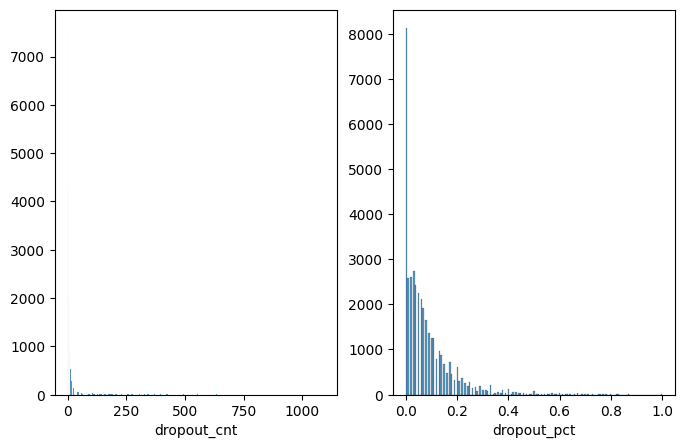

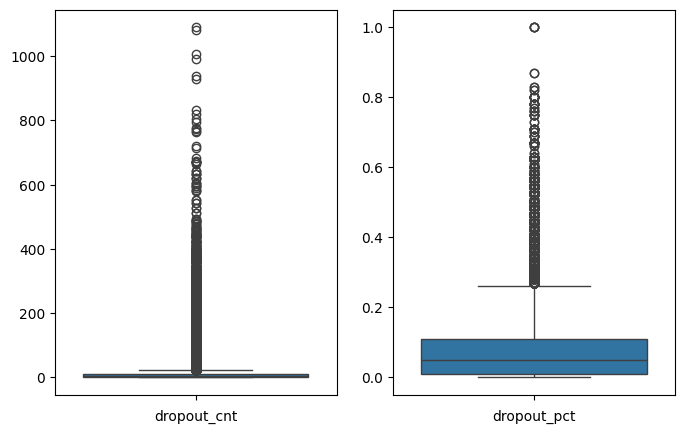

In [13]:
hist(['dropout_cnt','dropout_pct'])
box(['dropout_cnt','dropout_pct'])

From the heatmap, we can observe that the 'enroll_cnt', 'grad_cnt', 'local_cnt', 'reg_cnt', 'still_enr_cnt'and ged_cnt have strong relationship with the response variable "drop_cnt", these features may be the important predictor of dropout. We should consider multicollinearity during modeling, we can use regularization techniques to mitigate its potential impact on model performance.

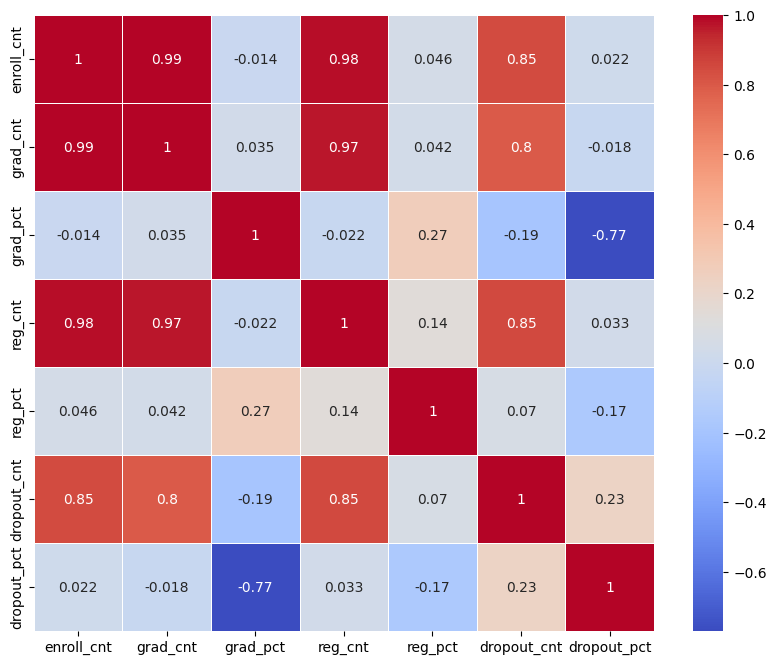

In [14]:
new_raw = ['enroll_cnt', 'grad_cnt', 'grad_pct', 'reg_cnt', 'reg_pct', 'dropout_cnt', 'dropout_pct']
data_subset = school_raw[new_raw]
correlation_matrix = data_subset.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.show()

# 3. Data Preparation

### 3.1 reg_pct

First, we create a new categorical indicator variable reg_pct_level having the three 
categorizations described above (“low”, “medium”, and “high”). And remove the “reg_pct” and “reg_cnt” attributes from the dataframe.

Low means that the percentage of diplomas earned by a school student subgroup is less than half of the median percentage of all diplomas; medium means that the percentage is between 0.5 and 1.5 times the median; high means that it is more than 1.5 times the median.

In [15]:
# Calculate the median
school_raw.reg_pct.median()*0.5, school_raw.reg_pct.median()*1.5

(0.215, 0.645)

So the values are
- low < 0.215
- medium: 0.215 ~ 0.645
- high > 0.645

In [16]:
# Create a list
reg_pct_level = []

# Loop through 'reg_pct' column
for a in school_raw['reg_pct']:
    if a < 0.215:
        reg_pct_level.append('low')
    elif a > 0.645:
        reg_pct_level.append('high')
    else:
        reg_pct_level.append('medium')
        
# Add reg_pct_level to the DataFrame
school_raw['reg_pct_level'] = reg_pct_level
school_raw.head()

,report_school_year,aggregation_index,aggregation_type,aggregation_name,nrc_code,nrc_desc,county_code,county_name,nyc_ind,membership_desc,subgroup_code,subgroup_name,enroll_cnt,grad_cnt,grad_pct,reg_cnt,reg_pct,dropout_cnt,dropout_pct,reg_pct_level
0,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,1,All Students,658.0,464.0,0.71,310.0,0.47,148,0.22,medium
1,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,2,Female,324.0,246.0,0.76,169.0,0.52,65,0.20,medium
2,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,3,Male,334.0,218.0,0.65,141.0,0.42,83,0.25,medium
4,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,5,Black,367.0,248.0,0.68,183.0,0.50,91,0.25,medium
5,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,6,Hispanic,98.0,58.0,0.59,40.0,0.41,28,0.29,medium


In [17]:
# Remove the column 'reg_pct' and 'reg_cnt'
df_school = school_raw.drop(['reg_pct','reg_cnt'],axis=1)

school_raw['reg_pct_level'].value_counts()

reg_pct_level
medium    32258
low        3915
high       3501
Name: count, dtype: int64

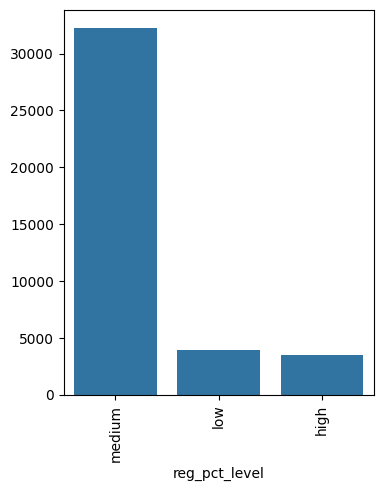

In [18]:
bar(['reg_pct_level'])

Based on this bar chart, we can see that the number of 'medium' registration percentage levels is much greater than the number of 'low' and 'high'. Specifically, the number of 'medium' exceeds 30,000, while the number of 'low' and 'high' are both below 10,000. This indicates that the data is imbalanced. For predictive modeling, we may need to employ techniques like SMOTE to balance the dataset before proceeding.

### 3.2 Data Transformation
First we need to deal with the subgroups within the dataset.  

Now we will melt the subgroups in variale. From the subgroups valuecounts below, we can see that there are 24 subgroups. Since we are pridicting the dropout count and we need each observation to be weighted evenly, we can only use the subgroup "All Students" for observation. To make full use of the data, we will take the percentage of each subgroup and melt them into new variables.

The valuecounts suggests that there are 4074 sets of subgroups and many subgroups are missing. We will select the subgroups that has over 4000 sets to make sure the percentage data is convincing.

In [19]:
df_school["subgroup_name"].value_counts()

subgroup_name
All Students                         4046
Male                                 3970
Female                               3970
Economically Disadvantaged           3918
Not Economically Disadvantaged       3918
General Education Students           3632
Students with Disabilities           3632
White                                2790
Hispanic                             1878
Black                                1416
Asian/Pacific Islander               1122
Homeless                              962
Not Homeless                          962
English Language Learner              872
Not English Language Learner          872
Multiracial                           708
Formerly English Language Learner     572
American Indian/Alaska Native         270
In Foster Care                         36
Not in Foster Care                     36
Parent in Armed Forces                 28
Parent Not in Armed Forces             28
Migrant                                18
Not Migrant         

We filter out other subgroups and keep the subgroup of all students, and calculate the percentage for each school under different years. 
So we have __Parent Not in Armed Forces , Not Homeless , Not Migrant ,Not in Foster Care ,Not English Language Learner , Male ,General Education Students, White ,Economically Disadvantaged ,Students with Disabilities__ as our new variables.  
However there are too many null values due to exsisted null values under certain subgroups. We will only take __Male_pct,Economically Disadvantaged_pct,General Education Students_pct and Students with Disabilities_pct__ as new variables.

In [20]:
df_reshaped=df_school[df_school['subgroup_name']=='All Students']
df_reshaped=df_reshaped.dropna()
grouped_membership= df_school.groupby('membership_desc')
for membership_name, membership in grouped_membership:
    grouped_school= membership.groupby('aggregation_name')
    for school_name, school in grouped_school:
        
        all_student = school[school['subgroup_name']=="All Students"]['enroll_cnt'].iloc[0]
        if pd.isna(all_student):
            continue
        all_student = int(all_student)


        for subgroup in ["Male", "Parent Not in Armed Forces", "Not Homeless", "Not Migrant", "Not in Foster Care", "Not English Language Learner", "General Education Students", "White", "Economically Disadvantaged", "Students with Disabilities"]:
            subgroup_row = school[school['subgroup_name'] == subgroup]
            if not subgroup_row.empty:
                subgroup_enroll = subgroup_row['enroll_cnt'].iloc[0]
            else:
                subgroup_enroll = np.nan
            
            if not pd.isna(subgroup_enroll) and all_student != 0:
                subgroup_pct = int(subgroup_enroll) / all_student
            else:
                subgroup_pct = np.nan
            
            mask_membership = df_reshaped['membership_desc'] == membership_name
            mask_aggregation = df_reshaped['aggregation_name'] == school_name

            # Apply conditions and assign value to respective subgroup column
            df_reshaped.loc[mask_membership & mask_aggregation, f'{subgroup}_pct'] = subgroup_pct

display(df_reshaped[["Male_pct", "Parent Not in Armed Forces_pct", "Not Homeless_pct", "Not Migrant_pct", "Not in Foster Care_pct", "Not English Language Learner_pct", "General Education Students_pct", "White_pct", "Economically Disadvantaged_pct", "Students with Disabilities_pct"]].isnull().sum().sort_values())
excluded_columns = ["Parent Not in Armed Forces_pct", "Not Homeless_pct", "Not Migrant_pct", "Not in Foster Care_pct", "Not English Language Learner_pct","White_pct" ]
df_reshaped = df_reshaped.drop(columns=excluded_columns)
df_reshaped[["Male_pct", "General Education Students_pct", "Economically Disadvantaged_pct", "Students with Disabilities_pct"]]

Male_pct                              76
Economically Disadvantaged_pct       128
General Education Students_pct       414
Students with Disabilities_pct       414
White_pct                           1256
Not Homeless_pct                    3084
Not English Language Learner_pct    3174
Not in Foster Care_pct              4010
Parent Not in Armed Forces_pct      4018
Not Migrant_pct                     4028
dtype: int64

,Male_pct,General Education Students_pct,Economically Disadvantaged_pct,Students with Disabilities_pct
0,0.507599,0.826748,0.495441,0.173252
22,0.505900,0.831858,0.501475,0.168142
44,0.514205,0.862216,0.582386,0.137784
66,0.505900,0.831858,0.501475,0.168142
88,0.514205,0.862216,0.582386,0.137784
...,...,...,...,...
73074,0.591837,0.775510,0.653061,0.224490
73090,0.627119,0.813559,0.440678,0.186441
73105,0.591837,0.775510,0.653061,0.224490
73121,0.627119,0.813559,0.440678,0.186441


### 3.3 Data Cleaning

The dataset has variables that are duplicated. In variable "membership_desc", the rows for "2013 Total Cohort - 6 Year Outcom" and "2013 Total Cohort - 6 Year Outcome - August 201" have extremely similar data.

In [21]:
conditions_to_drop = (df_reshaped['membership_desc'] == '2014 Total Cohort - 5 Year Outcome - August 2019') | \
                     (df_reshaped['membership_desc'] == '2015 Total Cohort - 4 Year Outcome - August 2019') | \
                     (df_reshaped['membership_desc'] == '2013 Total Cohort - 6 Year Outcome - August 2019')


df_cleaned = df_reshaped[~conditions_to_drop]

The percentage variables we add in 3.1 has some null values and we can simply impute them since their are only a few.

In [22]:
# Columns to impute nulls
columns_to_impute = ['Male_pct', 'Economically Disadvantaged_pct', 'General Education Students_pct', 'Students with Disabilities_pct']
for column in columns_to_impute:
    df_cleaned[column].fillna(df_cleaned[column].median(), inplace=True)


C:\Users\86136\AppData\Local\Temp\ipykernel_79012\3796036201.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[column].fillna(df_cleaned[column].median(), inplace=True)


In [23]:
df_cleaned.head()

,report_school_year,aggregation_index,aggregation_type,aggregation_name,nrc_code,nrc_desc,county_code,county_name,nyc_ind,membership_desc,...,enroll_cnt,grad_cnt,grad_pct,dropout_cnt,dropout_pct,reg_pct_level,Male_pct,General Education Students_pct,Economically Disadvantaged_pct,Students with Disabilities_pct
0,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,...,658.0,464.0,0.71,148,0.22,medium,0.507599,0.826748,0.495441,0.173252
22,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2014 Total Cohort - 5 Year Outcome,...,678.0,474.0,0.70,140,0.21,medium,0.505900,0.831858,0.501475,0.168142
44,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2015 Total Cohort - 4 Year Outcome,...,704.0,452.0,0.64,115,0.16,medium,0.514205,0.862216,0.582386,0.137784
132,2018-19,3,District,BERNE-KNOX-WESTERLO CENTRAL SCHOOL DISTRICT,5,Average Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,...,63.0,58.0,0.92,3,0.05,medium,0.603175,0.825397,0.317460,0.174603
147,2018-19,3,District,BERNE-KNOX-WESTERLO CENTRAL SCHOOL DISTRICT,5,Average Needs,1,ALBANY,0,2014 Total Cohort - 5 Year Outcome,...,76.0,71.0,0.93,1,0.01,medium,0.552632,0.921053,0.368421,0.078947


### 3.4 Column Drop

Since the models we are using are for numeric data, we will drop all the categorical variables. And also drop the variables make no sense according to EDA.

In [24]:
columns_to_drop = ['report_school_year', 'aggregation_index', 'aggregation_type',
       'aggregation_name', 'nrc_desc','county_name', 'subgroup_code','subgroup_name']
df_school = df_cleaned.drop(columns=columns_to_drop)
df_school.head()


,nrc_code,county_code,nyc_ind,membership_desc,enroll_cnt,grad_cnt,grad_pct,dropout_cnt,dropout_pct,reg_pct_level,Male_pct,General Education Students_pct,Economically Disadvantaged_pct,Students with Disabilities_pct
0,3,1,0,2013 Total Cohort - 6 Year Outcome,658.0,464.0,0.71,148,0.22,medium,0.507599,0.826748,0.495441,0.173252
22,3,1,0,2014 Total Cohort - 5 Year Outcome,678.0,474.0,0.70,140,0.21,medium,0.505900,0.831858,0.501475,0.168142
44,3,1,0,2015 Total Cohort - 4 Year Outcome,704.0,452.0,0.64,115,0.16,medium,0.514205,0.862216,0.582386,0.137784
132,5,1,0,2013 Total Cohort - 6 Year Outcome,63.0,58.0,0.92,3,0.05,medium,0.603175,0.825397,0.317460,0.174603
147,5,1,0,2014 Total Cohort - 5 Year Outcome,76.0,71.0,0.93,1,0.01,medium,0.552632,0.921053,0.368421,0.078947


In [25]:
df_res = df_school['reg_pct_level']

### 3.5 Numerical data

In [26]:
df_num = df_school[[            
'enroll_cnt','grad_cnt','grad_pct','dropout_cnt','dropout_pct',
'Male_pct','General Education Students_pct','Economically Disadvantaged_pct',
'Students with Disabilities_pct']]

In [27]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a MinMaxScaler instance
scaler = MinMaxScaler()

# Apply MinMaxScaler to our numeric DataFrame df_num
df_num_scaled = scaler.fit_transform(df_num)

# Convert the scaled data back into a DataFrame, preserving column names and indices
df_num_scaled = pd.DataFrame(df_num_scaled, columns=df_num.columns, index=df_num.index)

# Preview the scaled DataFrame
df_num_scaled.head()


,enroll_cnt,grad_cnt,grad_pct,dropout_cnt,dropout_pct,Male_pct,General Education Students_pct,Economically Disadvantaged_pct,Students with Disabilities_pct
0,0.071203,0.062040,0.71,0.135655,0.282051,0.454235,0.817732,0.529287,0.182268
22,0.073383,0.063377,0.70,0.128323,0.269231,0.450757,0.824775,0.536038,0.175225
44,0.076219,0.060436,0.64,0.105408,0.205128,0.467758,0.866608,0.626555,0.133392
132,0.006324,0.007755,0.92,0.002750,0.064103,0.649895,0.815871,0.330177,0.184129
147,0.007742,0.009493,0.93,0.000917,0.012821,0.546425,0.947685,0.387188,0.052315


### 3.6 Categorical data

In [28]:
df_cat = df_school[[            
'nrc_code',
'nyc_ind',
'membership_desc',
'county_code']]

In [29]:
df_cat['county_code'].value_counts()

county_code
58    164
28    132
66    130
14     84
26     54
     ... 
7       9
20      7
55      6
68      6
35      3
Name: count, Length: 62, dtype: int64

In [30]:
# Replace county_code values based on the top five categories
df_cat['county_code'] = df_cat['county_code'].apply(lambda x: str(x) if x in [58, 28, 66, 14, 26] else 'other')

# Dummy the categorical columns
df_cate = pd.get_dummies(df_cat, columns=['nrc_code','membership_desc','county_code'])

df_cate.head(5)

C:\Users\86136\AppData\Local\Temp\ipykernel_79012\627819180.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat['county_code'] = df_cat['county_code'].apply(lambda x: str(x) if x in [58, 28, 66, 14, 26] else 'other')


,nyc_ind,nrc_code_1,nrc_code_2,nrc_code_3,nrc_code_4,nrc_code_5,nrc_code_6,membership_desc_2013 Total Cohort - 6 Year Outcome,membership_desc_2014 Total Cohort - 5 Year Outcome,membership_desc_2015 Total Cohort - 4 Year Outcome,county_code_14,county_code_26,county_code_28,county_code_58,county_code_66,county_code_other
0,0,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True
22,0,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True
44,0,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True
132,0,False,False,False,False,True,False,True,False,False,False,False,False,False,False,True
147,0,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True


In [31]:
# combine the numerical and categorical values
df_school = pd.concat([df_num_scaled, df_cate, df_res], axis=1)
df_school.head()

,enroll_cnt,grad_cnt,grad_pct,dropout_cnt,dropout_pct,Male_pct,General Education Students_pct,Economically Disadvantaged_pct,Students with Disabilities_pct,nyc_ind,...,membership_desc_2013 Total Cohort - 6 Year Outcome,membership_desc_2014 Total Cohort - 5 Year Outcome,membership_desc_2015 Total Cohort - 4 Year Outcome,county_code_14,county_code_26,county_code_28,county_code_58,county_code_66,county_code_other,reg_pct_level
0,0.071203,0.062040,0.71,0.135655,0.282051,0.454235,0.817732,0.529287,0.182268,0,...,True,False,False,False,False,False,False,False,True,medium
22,0.073383,0.063377,0.70,0.128323,0.269231,0.450757,0.824775,0.536038,0.175225,0,...,False,True,False,False,False,False,False,False,True,medium
44,0.076219,0.060436,0.64,0.105408,0.205128,0.467758,0.866608,0.626555,0.133392,0,...,False,False,True,False,False,False,False,False,True,medium
132,0.006324,0.007755,0.92,0.002750,0.064103,0.649895,0.815871,0.330177,0.184129,0,...,True,False,False,False,False,False,False,False,True,medium
147,0.007742,0.009493,0.93,0.000917,0.012821,0.546425,0.947685,0.387188,0.052315,0,...,False,True,False,False,False,False,False,False,True,medium


### 3.7 Feature Selection

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from imblearn.over_sampling import SMOTE

In [33]:
X = df_school.drop('reg_pct_level', axis=1)
y = df_res

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Apply SMOTE on training data
sm = SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

X_train_res.head(1)

,enroll_cnt,grad_cnt,grad_pct,dropout_cnt,dropout_pct,Male_pct,General Education Students_pct,Economically Disadvantaged_pct,Students with Disabilities_pct,nyc_ind,...,nrc_code_6,membership_desc_2013 Total Cohort - 6 Year Outcome,membership_desc_2014 Total Cohort - 5 Year Outcome,membership_desc_2015 Total Cohort - 4 Year Outcome,county_code_14,county_code_26,county_code_28,county_code_58,county_code_66,county_code_other
0,0.010904,0.013103,0.93,0.0055,0.076923,0.389937,0.859617,0.465134,0.140383,0,...,False,False,True,False,False,False,False,False,False,True


In [34]:
# Detect highly correlated features
def correlation(data,threshold):
# Set of all the names of correlated columns
    col_corr = set()
    corr_matrix = data.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
# We care about absolute coef value
            if abs(corr_matrix.iloc[i,j]) > threshold:
                col_name = corr_matrix.columns[i]
                col_corr.add(col_name)
    return col_corr
corr_features = correlation(X_train_res,0.85)
corr_features

{'Students with Disabilities_pct', 'dropout_cnt', 'grad_cnt', 'nrc_code_1'}

From the above output, these features are highly correlated. In case of overfitting,we remove the first three features.

In [35]:
corr_features = {('Students with Disabilities_pct'),
 ('dropout_cnt'),
 ('grad_cnt'),
 ('nrc_code_1')}
# Update the dataframe based on the result from correlation function
X_train_res.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

Step forward feature selection for training data

In [36]:
import warnings
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Ignoring FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Setting up the SFS
sfs = SFS(RandomForestClassifier(), 
          k_features=12, 
          forward=True, 
          floating=False, 
          verbose=2,
          scoring='accuracy',
          cv=3)

# Fitting the SFS to the training data
sfs = sfs.fit(np.array(X_train_res), np.array(y_train_res))

# Printing the indices of the selected features
selected_features = list(sfs.k_feature_idx_)
print("Selected features indices:", selected_features)

# Printing the names of the selected features
if isinstance(X_train_res, pd.DataFrame):
    selected_feature_names = X_train_res.columns[list(sfs.k_feature_idx_)].tolist()
    print("Selected feature names:", selected_feature_names)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   19.4s finished

[2024-03-31 21:25:58] Features: 1/12 -- score: 0.6983615363953802[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   34.7s finished

[2024-03-31 21:26:33] Features: 2/12 -- score: 0.7977437550362612[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   36.3s finished

[2024-03-31 21:27:09] Features: 3/12 -- score: 0.8726833199033038[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

Selected features indices: [1, 2, 3, 4, 5, 8, 10, 12, 14, 17, 18, 19]
Selected feature names: ['grad_pct', 'dropout_pct', 'Male_pct', 'General Education Students_pct', 'Economically Disadvantaged_pct', 'nrc_code_3', 'nrc_code_5', 'membership_desc_2013 Total Cohort - 6 Year Outcome', 'membership_desc_2015 Total Cohort - 4 Year Outcome', 'county_code_28', 'county_code_58', 'county_code_66']


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.6s finished

[2024-03-31 21:31:52] Features: 12/12 -- score: 0.9486972871340317

Because the first feature is low. We will drop it to improve the performance.

In [37]:
# Locate the columns
columns_positions = [0, 1, 2, 3, 4, 5, 7, 8, 9, 12]
X1_train = X_train_res.iloc[:, columns_positions]
X_test = X_test.iloc[:, columns_positions]
X1_train

,enroll_cnt,grad_pct,dropout_pct,Male_pct,General Education Students_pct,Economically Disadvantaged_pct,nrc_code_2,nrc_code_3,nrc_code_4,membership_desc_2013 Total Cohort - 6 Year Outcome
0,0.010904,0.930000,0.076923,0.389937,0.859617,0.465134,False,False,True,False
1,0.027151,0.990000,0.012821,0.591814,0.964247,0.168822,False,False,False,False
2,0.074147,0.900000,0.089744,0.479025,0.805014,0.518873,False,False,False,True
3,0.008287,0.910000,0.115385,0.577685,0.920376,0.278878,False,False,False,True
4,0.008069,0.820000,0.179487,0.425722,0.899487,0.244088,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...
3718,0.024872,0.977295,0.003468,0.404948,0.905288,0.126564,False,False,False,True
3719,0.002015,0.199087,0.294872,0.510948,0.161384,0.432140,False,False,False,False
3720,0.019764,0.947685,0.004927,0.438579,0.861960,0.098499,False,False,False,False
3721,0.038877,0.974068,0.012821,0.454593,0.875031,0.154853,False,False,False,True


# 4. Prepped Data Overview

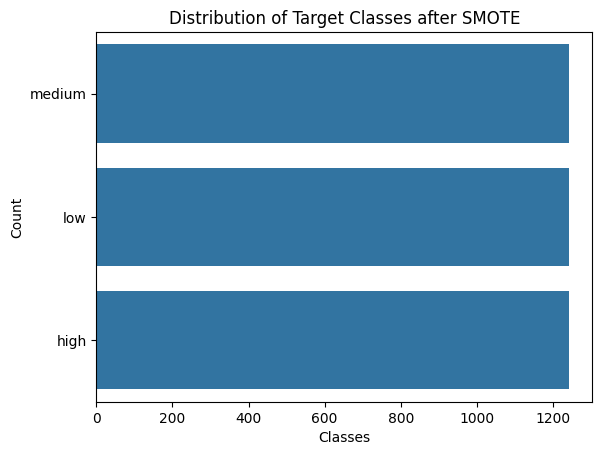

In [38]:
sns.countplot(y_train_res)

plt.title('Distribution of Target Classes after SMOTE')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

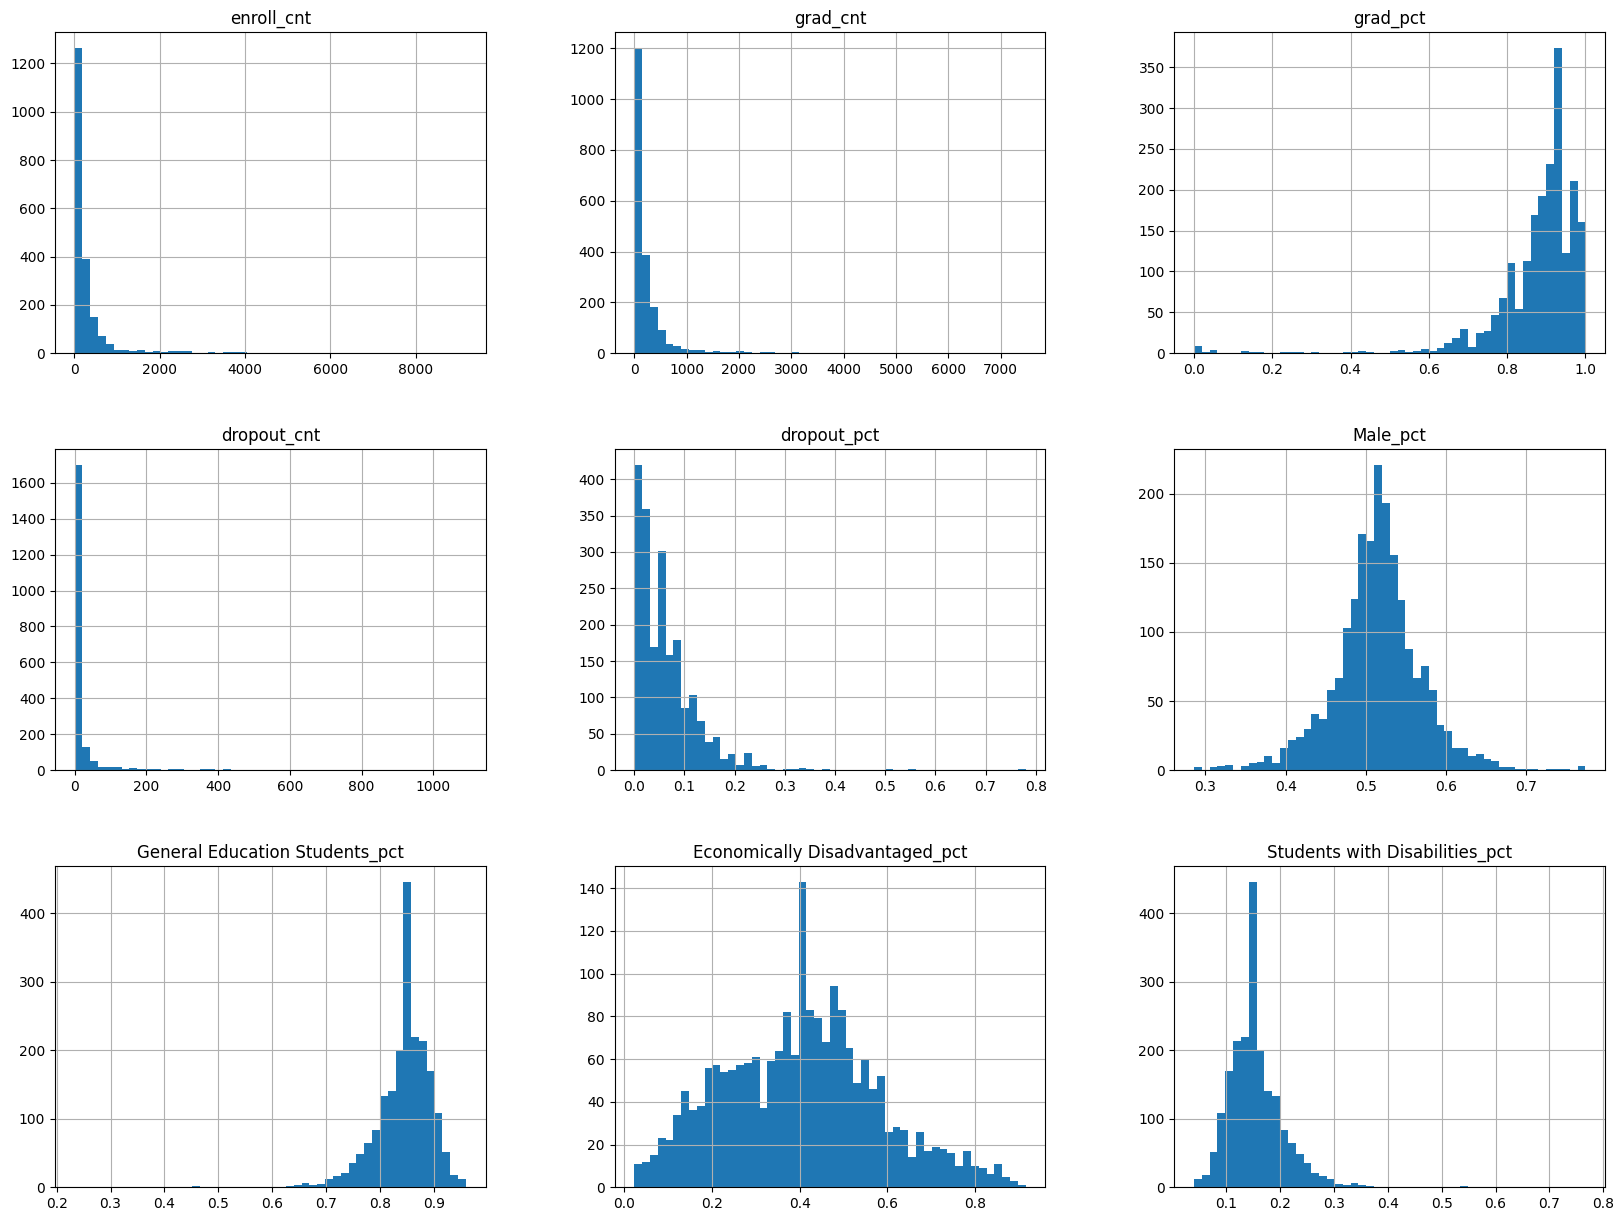

In [39]:
df_num.hist(bins=50, figsize=(20,15))
plt.show()

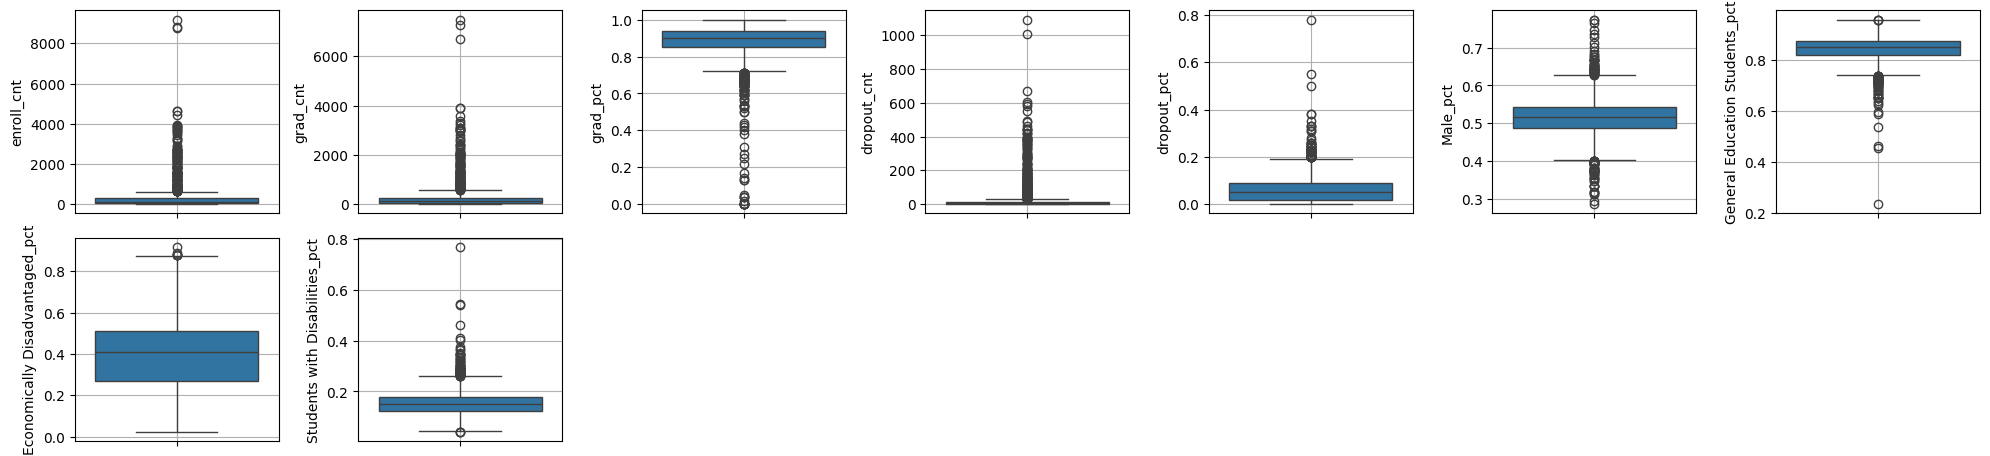

In [40]:
plt.figure(figsize = (20, 16))
for i, col in enumerate(df_num):
    plt.subplot(7,7, i + 1)
    sns.boxplot(data=df_num,y=col,orient="v")
    plt.grid()
    plt.tight_layout()

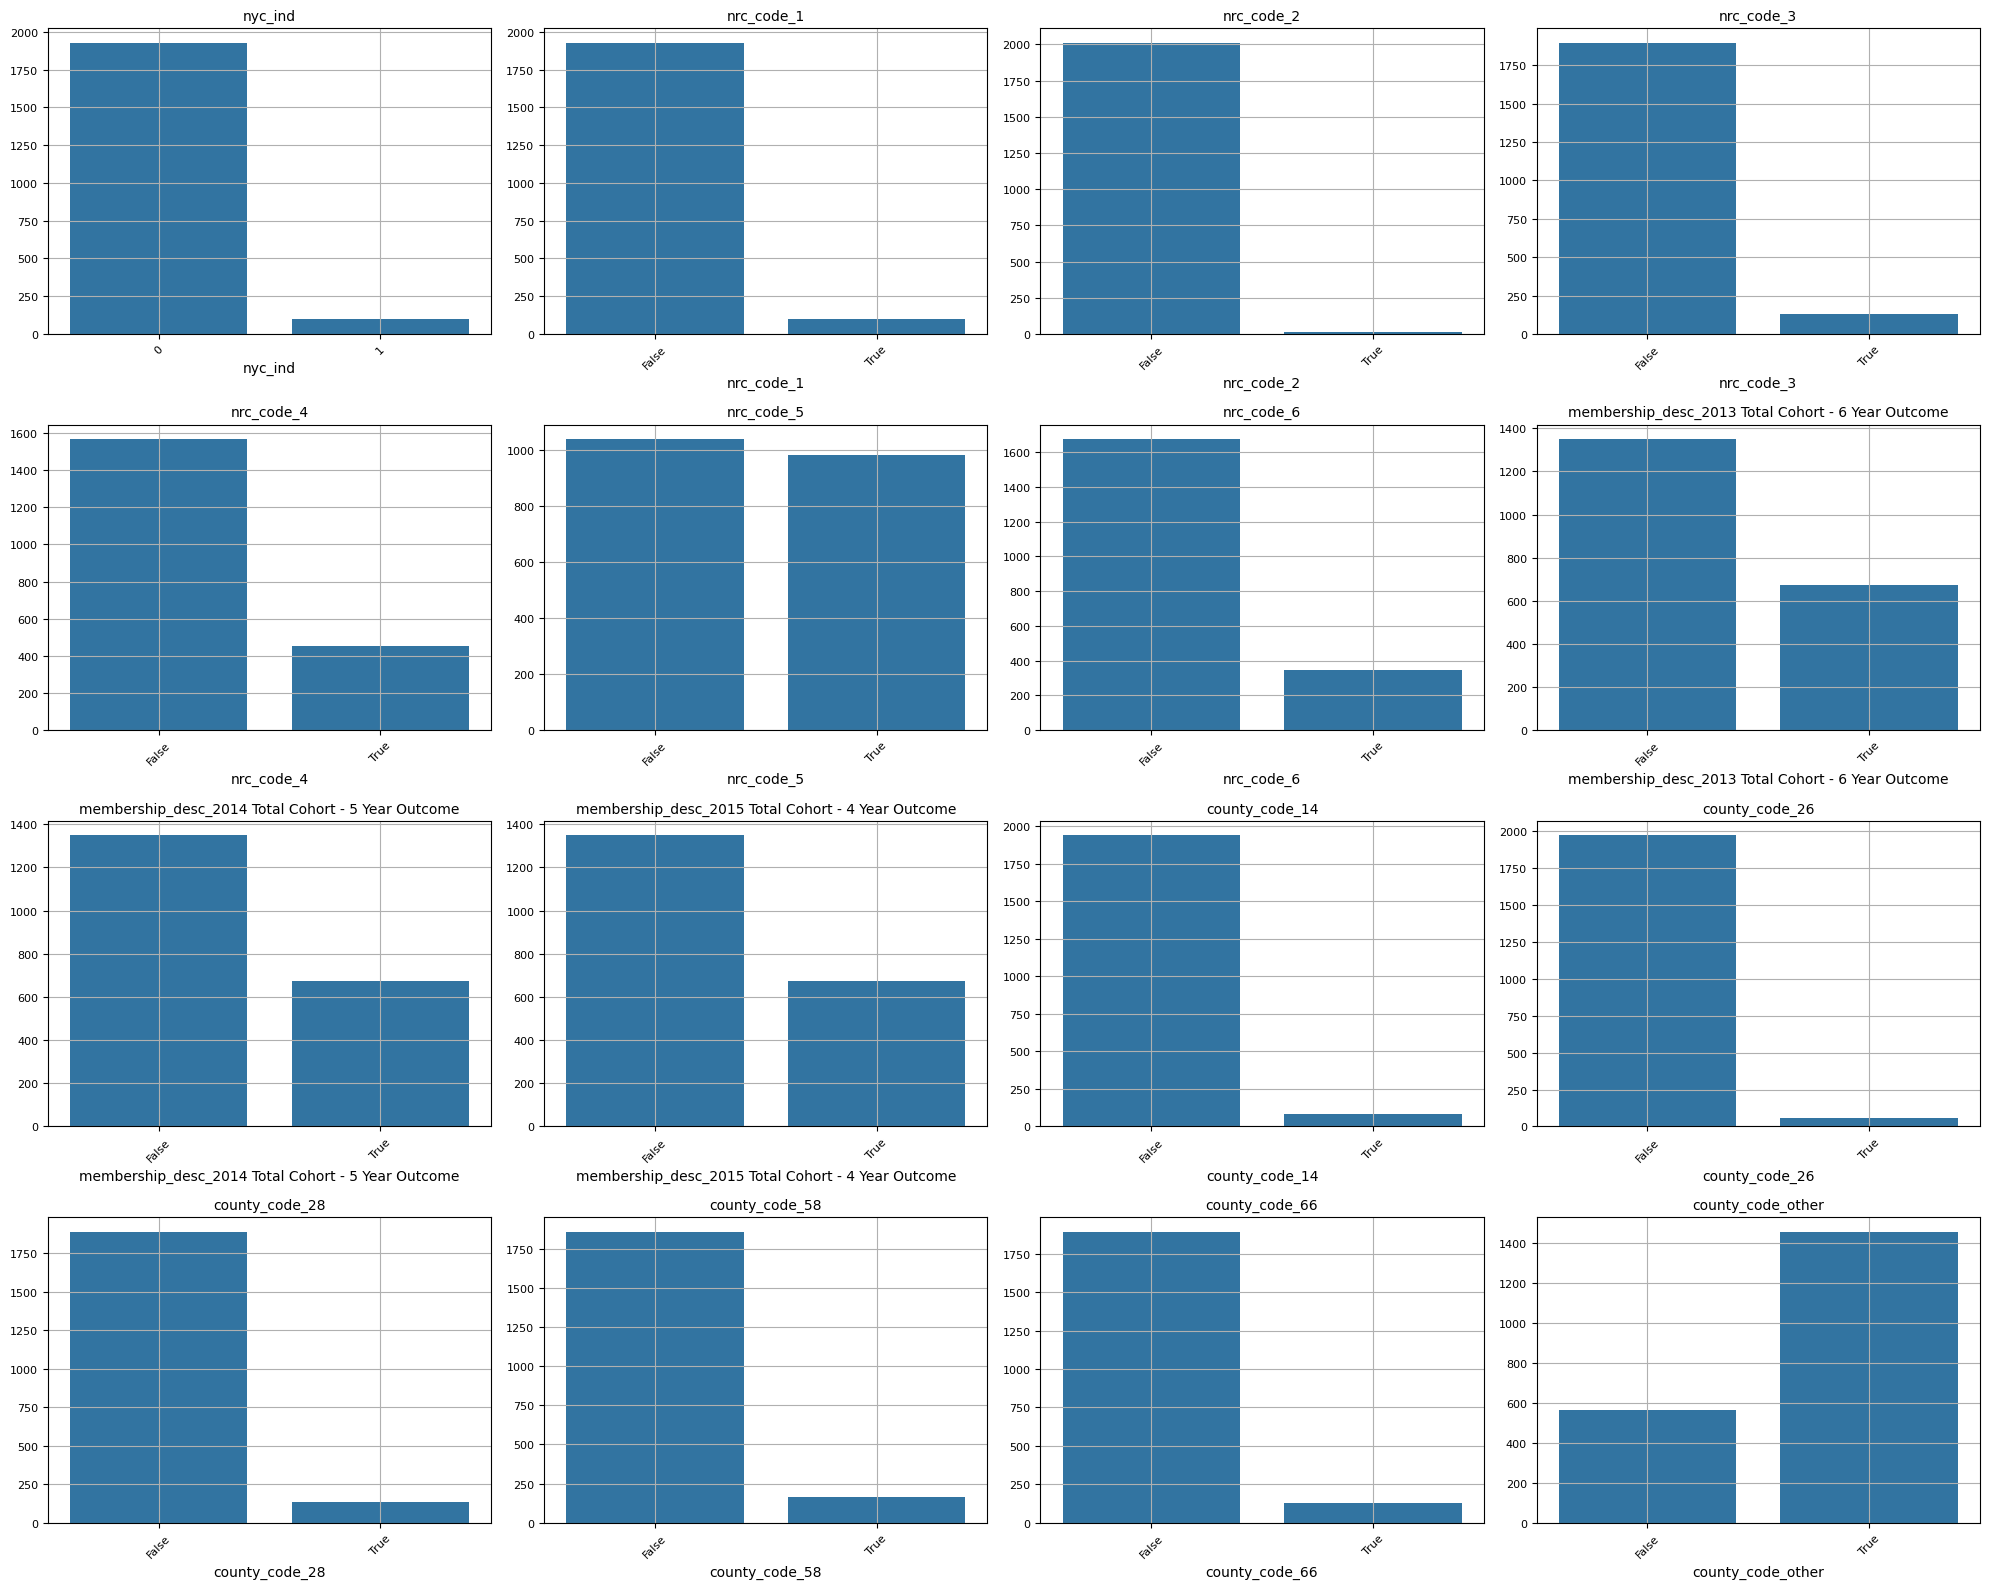

In [41]:
# Create bar plot for categorical
plt.figure(figsize=(20, 16))  
n_cols = 4 
n_rows = int(np.ceil(len(df_cate.columns) / n_cols)) 

for i, col in enumerate(df_cate.columns):
    plt.subplot(n_rows, n_cols, i + 1)  # Adjust the number of rows and columns
    sns.barplot(x=df_cate[col].value_counts().index, y=df_cate[col].value_counts().values)
    plt.title(col, fontsize=10)  # Adjust the title font size if necessary
    plt.xticks(rotation=45, fontsize=8)  # Rotate the x-axis labels to prevent overlap
    plt.yticks(fontsize=8)
    plt.grid(True)  

plt.tight_layout()  # Adjust the layout to fit the subplots
plt.show()

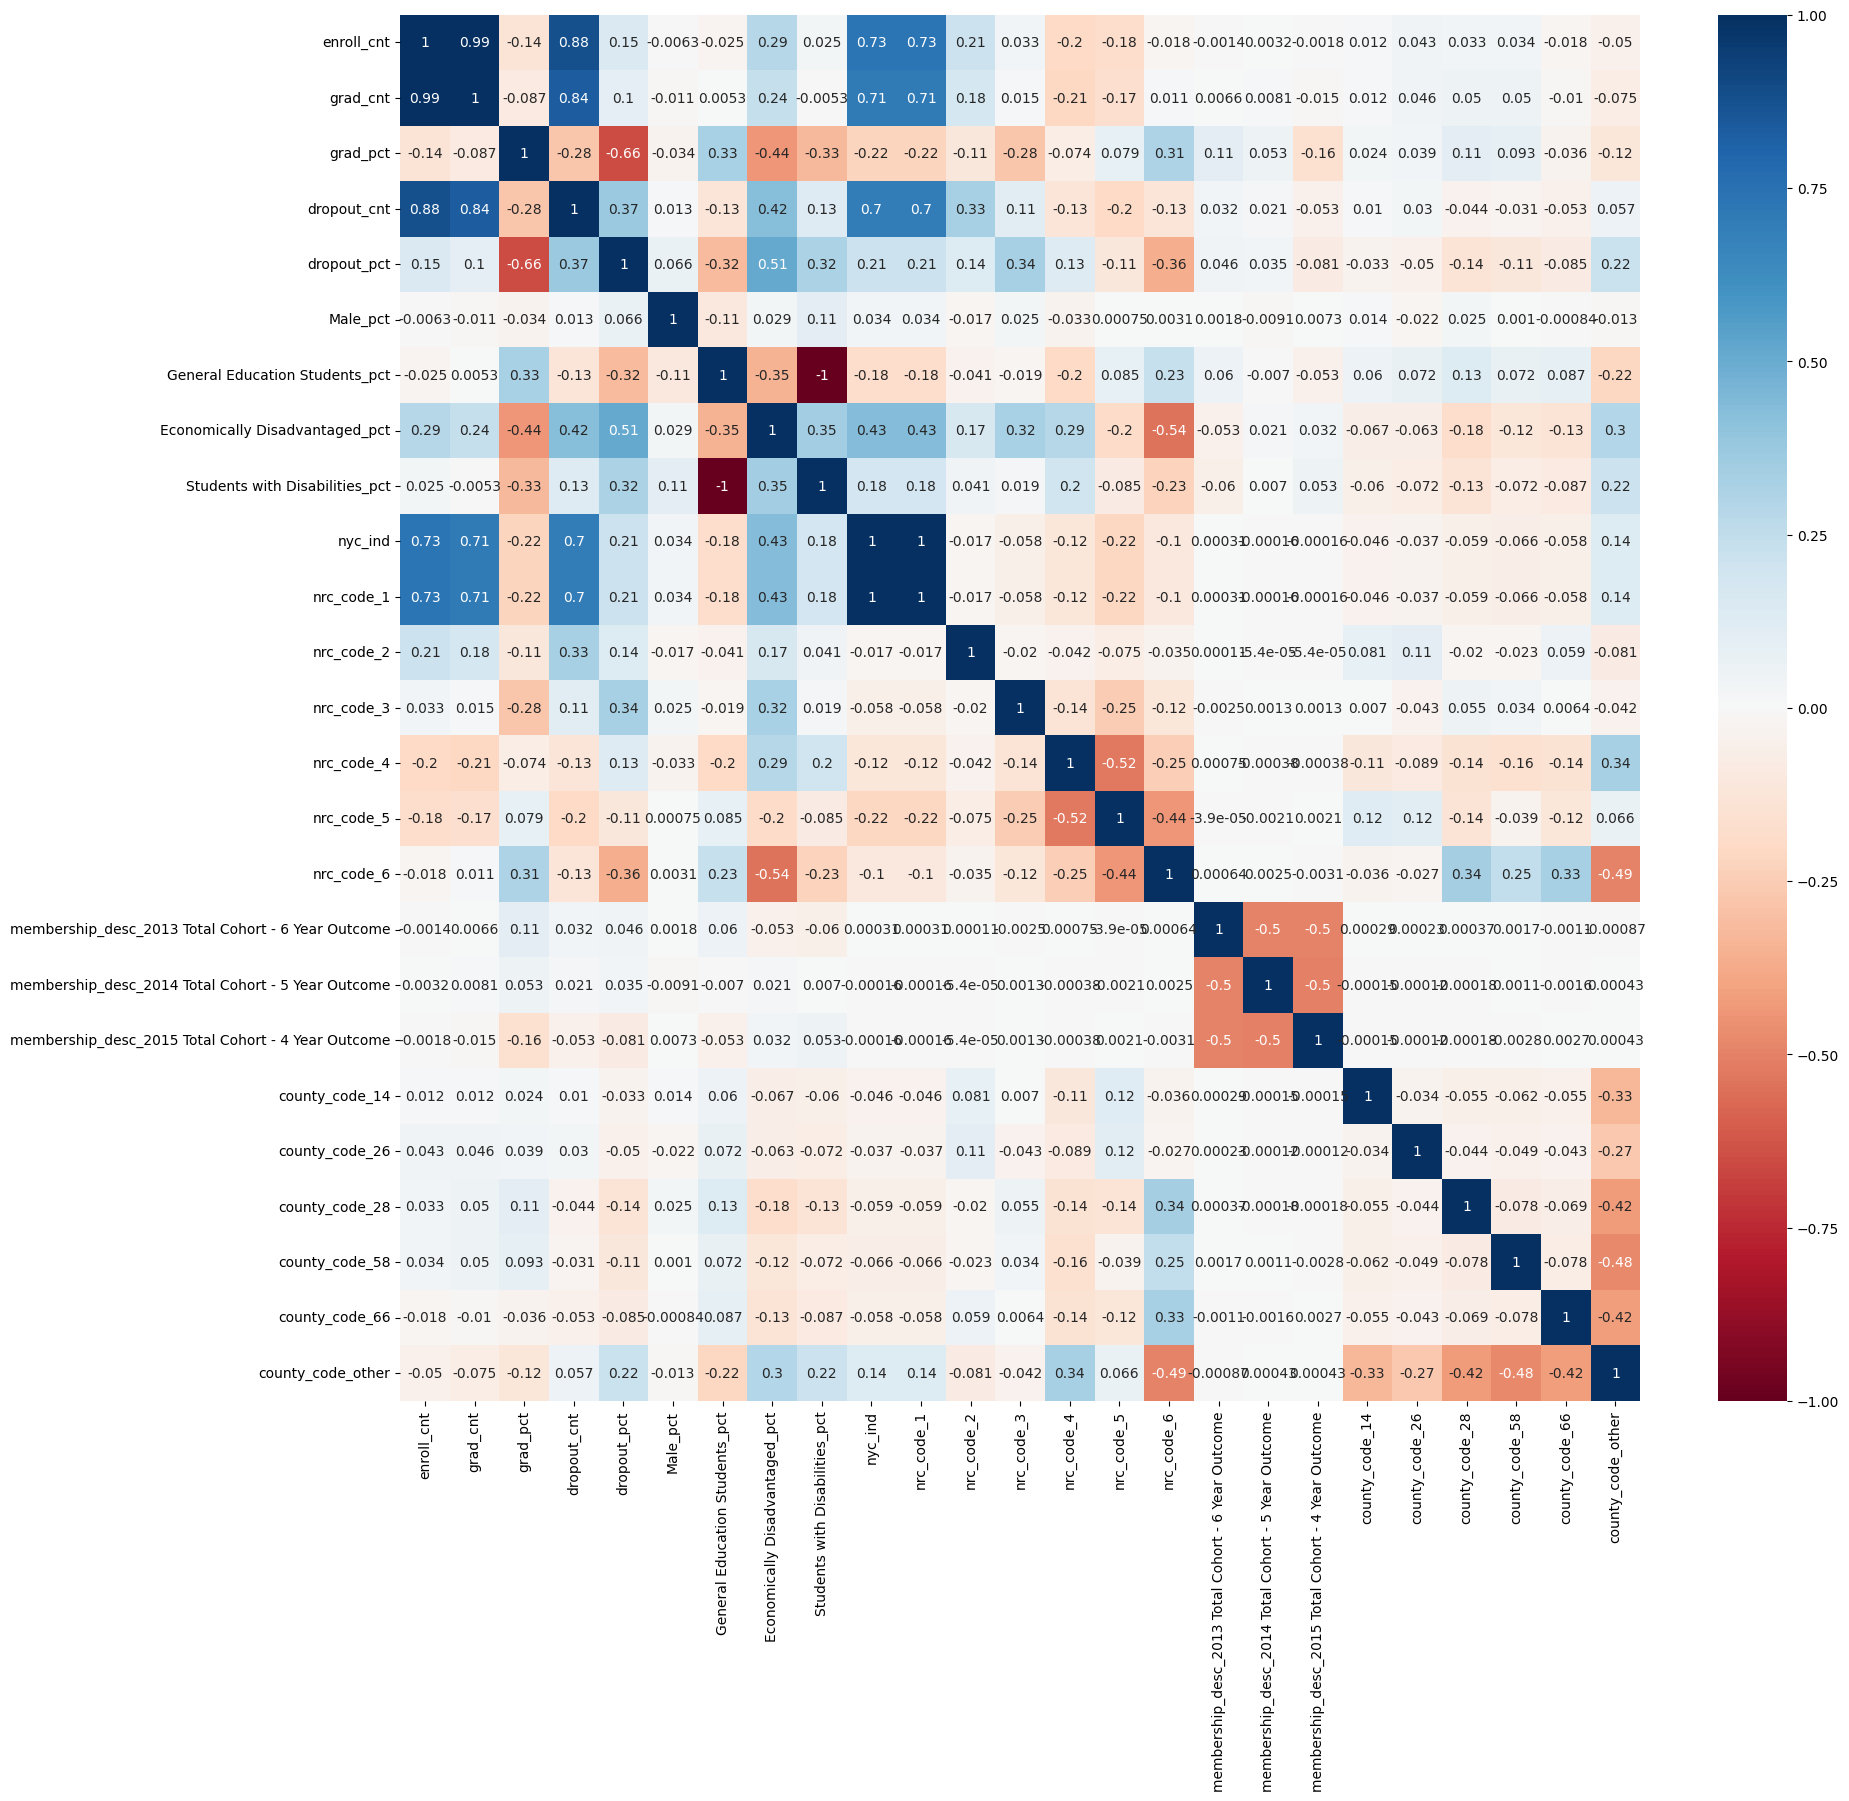

In [42]:
# Drop the 'reg_pct_level' column from df_school
df_school_without_reg_pct_level = df_school.drop('reg_pct_level', axis=1)

# Calculate the correlation matrix
corr = df_school_without_reg_pct_level.corr()
plt.figure(figsize=(20,18))

# Plot the heatmap
sns.heatmap(corr, cmap="RdBu", xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)

# Show the heatmap
plt.show()

# 5 Decision Tree + Random Forest Modeling 

### 5.1 Decision Tree

In this part. We will implement a grid search with cross-validation using GridSearchCV from sklearn.model_selection. This method systematically works through multiple combinations of parameter tunes, cross-validating as it goes to determine which tune gives the best performance.

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the model
DT_model = DecisionTreeClassifier(criterion='entropy', random_state=47)

# Define a range of max_depth values to explore
param_grid = {'max_depth': range(1, 200)}  # for example, from 1 to 200

# Set up GridSearchCV
grid_search = GridSearchCV(DT_model, param_grid, cv=5, scoring='accuracy')  # Adjust cv and scoring as necessary

# Fit the model
grid_search.fit(X1_train, y_train_res)

# Best max_depth value
best_depth = grid_search.best_params_['max_depth']
print("Best max_depth:", best_depth)

Best max_depth: 15


In [44]:
DT_model_1 = DecisionTreeClassifier(criterion = 'entropy',random_state=47)
DT_model_2 = DecisionTreeClassifier(criterion = 'entropy',max_depth=16, random_state=47)
#Training the decision tree classifier. 
DT_model_1.fit(X1_train, y_train_res)
DT_model_2.fit(X1_train, y_train_res)
cv_scores_1 = cross_val_score(DT_model_1, X1_train, y_train_res, cv=5)
cv_scores_2 = cross_val_score(DT_model_2, X1_train, y_train_res, cv=5)
print("DT_model_1 Mean accuracy:", cv_scores_1.mean())
print("DT_model_2 Mean accuracy:", cv_scores_2.mean())

DT_model_1 Mean accuracy: 0.8705434076639966
DT_model_2 Mean accuracy: 0.8708118640398356


### 5.2 Random Forest Modeling
In this section we will perform Random Forest Modeling on two different models. The two different models were set to have different n_estimators and max_depth. The n_estimators is set higher to have a more complex tree with the cost of computational resource; max_depth is to limit the depth of the tree to prevent the model form overfitting. As presented, the RF_model2 has a slightly better performance on the training set.

In [48]:
RF_model_1 = RandomForestClassifier(n_estimators=100, random_state=36)
RF_model_2 = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=36)
RF_model_1.fit(X1_train, y_train_res)
RF_model_2.fit(X1_train, y_train_res)

cv_scores_3 = cross_val_score(RF_model_1, X1_train, y_train_res, cv=5)
cv_scores_4 = cross_val_score(RF_model_2, X1_train, y_train_res, cv=5)
print("RF_model_1 Mean accuracy:", cv_scores_3.mean())
print("RF_model_2 Mean accuracy:", cv_scores_4.mean())

RF_model_1 Mean accuracy: 0.9282893122609511
RF_model_2 Mean accuracy: 0.9304369632676626


# 6. Select Models

In selecting the preferred model, we use the Accuracy, Precision, Recall and F1 Score. These criteria are commonly used for model selection analysis.

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

def metrics_test(model,name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # For ROC AUC calculation

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print the evaluation metrics
    print(f"\n{name} Metrics")
    print("Accuracy:", round(accuracy, 4))
    print("Precision:", round(precision, 4))
    print("Recall:", round(recall, 4))
    print("F1 Score:", round(f1, 4))
metrics_test(DT_model_1,"DT_model_1")
metrics_test(DT_model_2,"DT_model_2")
metrics_test(RF_model_1,"RF_model_1")
metrics_test(RF_model_2,"RF_model_2")


DT_model_1 Metrics
Accuracy: 0.7957
Precision: 0.8745
Recall: 0.7957
F1 Score: 0.8284

DT_model_2 Metrics
Accuracy: 0.7957
Precision: 0.8745
Recall: 0.7957
F1 Score: 0.8284

RF_model_1 Metrics
Accuracy: 0.855
Precision: 0.8816
Recall: 0.855
F1 Score: 0.8662

RF_model_2 Metrics
Accuracy: 0.855
Precision: 0.8845
Recall: 0.855
F1 Score: 0.8674


| Metric      | DT_model_1 | DT_model_2 | RF_model_1 | RF_model_2 |
|-------------|------------|------------|------------|------------|
| Accuracy    |   0.7957   |   0.7957   |   0.855    |   0.855    |
| Precision   |   0.8745   |   0.8745   |   0.8816   |   0.8845   |
| Recall      |   0.7957   |   0.7957   |   0.855    |   0.855    |
| F1 Score    |   0.8284   |   0.8284   |   0.8662   |   0.8674   |


Based on the metrics for the four models, we can analyze and select the best model as follows:

Accuracy: Both DT_model_1 and DT_model_2 have the same accuracy of 0.7957, while both RF_model_1 and RF_model_2 have a higher accuracy of 0.855. This indicates that the random forest models generally perform better in terms of overall accuracy compared to the decision tree models.

Precision: RF_model_2 has the highest precision of 0.8845, followed closely by RF_model_1 with a precision of 0.8816. The decision tree models (DT_model_1 and DT_model_2) have slightly lower precision scores of 0.8745. Higher precision indicates that the model has a lower false positive rate.

Recall: All models have the same recall score of 0.7957. Recall measures the model's ability to correctly identify positive instances out of all actual positive instances. In this case, all models have the same ability to recall positive instances.

F1 Score: RF_model_2 has the highest F1 score of 0.8674, followed by RF_model_1 with an F1 score of 0.8662. Both decision tree models (DT_model_1 and DT_model_2) have slightly lower F1 scores of 0.8284. The F1 score considers both precision and recall, providing a balanced evaluation of the model's performance.

Based on these analyses, we can conclude that RF_model_2 performs the best among the four models, as it has the highest precision and F1 score.

# 7. Conclusion

In this project, we analyze school performance metrics with an emphasis on graduation rates related indicators and etc. Through exploratory data analysis (EDA) and data cleaning, we have transformed and standardized our dataset in preparation for modeling. We employed decision tree, and random forest. By comparing the Accuracy, Precision, Recall, and F1 Score, we identified RF_model_2 as the most suitable for our analysis.

# 8. Reference

- https://timeseriesreasoning.com/contents/negative-binomial-regression-model/
- https://www.kaggle.com/prashant111/comprehensive-guide-on-feature-selection
- https://scikit-learn.org/stable/modules/model_evaluation.html
- https://www.xknote.com/ask/60c9b3246c1ff.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html 